[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/13_models_with_memory.ipynb)

# Chapter 13 - Models with Memory

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install -q watermark
  !pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git  
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior


# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,rethinking

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5
rethinking            : 0.1.0



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

## 13.1 Example: Multilevel tadpoles

##### Code 13.1


Reedfrogs dataset is about the tadpole mortality. The objective will be determine the `surv` out of an initial count, `density`.

Author explains that within each tank there are things that go unmeasured and these unmeasured factors create variation in survival across tanks.

These tanks are an example of **cluster** variable

He argues that both of the approaches - 
    * treat the tanks independetly i.e. each of them have their unique intecepts 
    * treat them togather 

have issues. 

for e.g.

    - unique intecepts will imply that we are not using information from other tanks.
    - all togather will have the problem ignoring varations in baseline survival 
    
A multilevel model, in which we simultaneously estimate both an intercept for each tank and the variation among tanks, is what we want !

This type of a model is called **Varying intercepts** model.
        


In [6]:
d = RethinkingDataset.ReedFrogs.get_dataset()
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


##### Code 13.2

Our simple model. This will give us 48 different intercepts. This means that it does not use the information available between each tank

In [7]:
d["tank"] = np.arange(d.shape[0])
alpha_sample_shape = d["tank"].shape[0]

# dat = dict(
#     S=tf.cast(d.surv.values, dtype=tf.float32),
#     N=tf.cast(d.density.values, dtype=tf.float32),
#     tank=d.tank.values)

tdf = dataframe_to_tensors("ReedFrogs", d, {
    "tank"    : tf.int32,
    "surv"    : tf.float32,
    "density" : tf.float32
})

def model_13_1(tid, density):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=alpha_sample_shape))
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, tid, axis=-1)))        
        
      S = yield tfd.Independent(tfd.Binomial(total_count=density, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_1 = model_13_1(tdf.tank, tdf.density)

In [8]:
NUM_CHAINS_FOR_13_1 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_1, alpha_sample_shape])
]

bijectors = [
    tfb.Identity()
]

posterior_13_1, trace_13_1 = sample_posterior(jdc_13_1,
                               observed_data=(tdf.surv,),
                               params=['alpha'],
                               num_chains=NUM_CHAINS_FOR_13_1,
                               init_state=init_state,
                               bijectors=bijectors)

az.summary(trace_13_1, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.74,0.75,0.54,2.84,0.03,0.02,642.94,480.60,1.01
alpha[1],2.37,0.86,1.09,3.80,0.04,0.03,655.66,597.10,1.00
alpha[2],0.77,0.68,-0.41,1.81,0.02,0.02,997.16,328.00,1.01
alpha[3],2.40,0.89,0.91,3.67,0.04,0.03,498.77,371.13,1.00
alpha[4],1.70,0.77,0.45,2.78,0.03,0.02,742.60,513.08,1.01
alpha[5],1.74,0.78,0.55,2.95,0.03,0.02,718.15,425.82,1.00
alpha[6],2.42,0.92,1.01,3.91,0.04,0.03,606.30,423.90,1.01
alpha[7],1.73,0.78,0.57,2.96,0.03,0.03,493.02,532.98,1.00
alpha[8],-0.39,0.62,-1.36,0.61,0.02,0.03,1440.86,334.49,1.00
alpha[9],1.71,0.81,0.45,2.86,0.03,0.03,833.31,337.49,1.00


##### Code 13.3

We now build a multilevel model, which adaptively pools information across tanks.

In order to do so, we must make the prior for the parameter **alpha** a function of some new parameters.

Prior itself has priors !


In [9]:
def model_13_2(tid, density):
    def _generator():     
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma), sample_shape=alpha_sample_shape)
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, tid, axis=-1)))              
        
      S = yield tfd.Independent(tfd.Binomial(total_count=density, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_2 = model_13_2(tdf.tank, tdf.density)

In [10]:
NUM_CHAINS_FOR_13_2 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_2]),
    tf.ones([NUM_CHAINS_FOR_13_2]),
    tf.zeros([NUM_CHAINS_FOR_13_2, alpha_sample_shape])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

In [11]:
posterior_13_2, trace_13_2 = sample_posterior(jdc_13_2,
                                       observed_data=(tdf.surv,),
                                       params=['a_bar', 'sigma', 'alpha'],
                                       num_chains=NUM_CHAINS_FOR_13_2, 
                                       init_state=init_state,
                                       bijectors=bijectors)

az.summary(trace_13_2, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.34,0.23,0.98,1.70,0.01,0.01,255.82,148.61,1.03
sigma,1.58,0.19,1.33,1.92,0.02,0.01,155.36,253.93,1.01
alpha[0],2.16,0.87,0.86,3.48,0.09,0.07,91.99,157.68,1.02
alpha[1],2.90,0.94,1.62,4.40,0.10,0.07,87.32,144.39,1.02
alpha[2],1.08,0.69,-0.12,2.02,0.07,0.05,110.21,136.51,1.02
alpha[3],3.05,1.24,0.82,4.78,0.44,0.32,8.45,79.42,1.19
alpha[4],2.34,0.84,1.07,3.65,0.09,0.06,88.18,125.12,1.02
alpha[5],2.14,0.97,0.58,3.43,0.16,0.13,42.74,73.52,1.06
alpha[6],2.99,0.97,1.46,4.44,0.16,0.12,38.54,57.40,1.08
alpha[7],2.23,1.01,0.83,3.70,0.16,0.13,45.91,30.76,1.02


##### Code 13.4

In [12]:
# we must compute the likelhood before using arviz to do comparison
def compute_and_store_log_likelihood_for_model_13_1():
    
    sample_alpha = posterior_13_1["alpha"]
    
    ds,_ = jdc_13_1.sample_distributions(value=[
        sample_alpha, 
        None
    ])
    
    log_likelihood_13_1 = ds[-1].distribution.log_prob(tdf.surv).numpy()

    # we need to insert this in the sampler_stats
    sample_stats_13_1 = trace_13_1.sample_stats

    coords = [sample_stats_13_1.coords['chain'], sample_stats_13_1.coords['draw'], np.arange(48)]

    sample_stats_13_1["log_likelihood"] = xr.DataArray(
        log_likelihood_13_1, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_1()

In [13]:
def compute_and_store_log_likelihood_for_model_13_2():
    
    sample_abar  = posterior_13_2["a_bar"]
    sample_sigma = posterior_13_2["sigma"]
    sample_alpha = posterior_13_2["alpha"]
    
    ds,_ = jdc_13_2.sample_distributions(value=[
        sample_abar, 
        sample_sigma, 
        sample_alpha, 
        None
    ])
    
    log_likelihood_13_2 = ds[-1].distribution.log_prob(tdf.surv).numpy()    

    # we need to insert this in the sampler_stats
    sample_stats_13_2 = trace_13_2.sample_stats

    coords = [sample_stats_13_2.coords['chain'], sample_stats_13_2.coords['draw'], np.arange(48)]

    sample_stats_13_2["log_likelihood"] = xr.DataArray(
        log_likelihood_13_2, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_2()

In [14]:
az.compare({"m13.1": trace_13_1, "m13.2": trace_13_2})

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Est

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m13.2,0,-105.402013,26.383810,0.000000,1.0,4.429056,0.000000,True,log
m13.1,1,-114.076082,32.576417,8.674069,0.0,2.751283,3.401877,True,log


##### Code 13.5

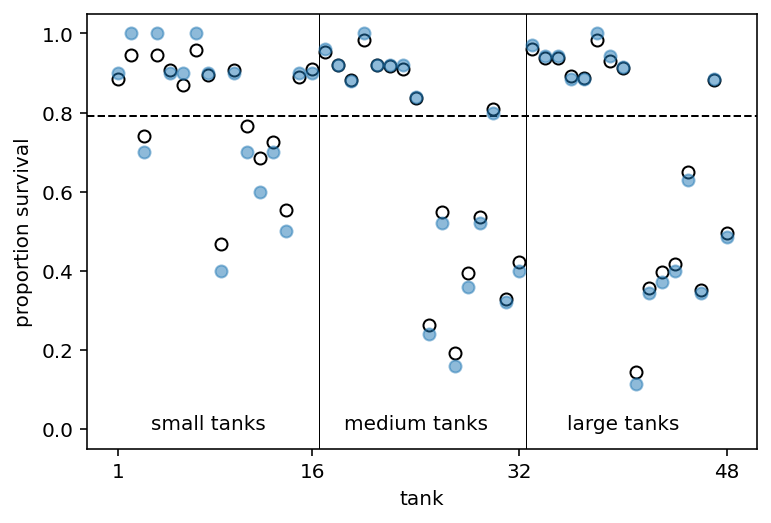

In [15]:
# compute median intercept for each tank
# also transform to probability with logistic

sample_alpha = trace_13_2.posterior["alpha"].values[0]
d["propsurv.est"] = tf.sigmoid(np.mean(sample_alpha, 0)).numpy()

# display raw proportions surviving in each tank
plt.plot(np.arange(1, 49), d.propsurv, "o", alpha=0.5, zorder=3)
plt.gca().set(ylim=(-0.05, 1.05), xlabel="tank", ylabel="proportion survival")
plt.gca().set(xticks=[1, 16, 32, 48], xticklabels=[1, 16, 32, 48])

# overlay posterior means
plt.plot(np.arange(1, 49), d["propsurv.est"], "ko", mfc="w")

sample_a_bar = trace_13_2.posterior["a_bar"].values[0]

# mark posterior mean probability across tanks
plt.gca().axhline(y=tf.reduce_mean(tf.sigmoid(sample_a_bar)).numpy(), c="k", ls="--", lw=1)

# draw vertical dividers between tank densities
plt.gca().axvline(x=16.5, c="k", lw=0.5)
plt.gca().axvline(x=32.5, c="k", lw=0.5)
plt.annotate("small tanks", (8, 0), ha="center")
plt.annotate("medium tanks", (16 + 8, 0), ha="center")
plt.annotate("large tanks", (32 + 8, 0), ha="center");

Here is how to read above plot -

* The dashed line locates the average proportion of survivors across all tanks
* The vertical lines divide tanks with different initial densities of tadpoles: small tanks (10 tad- poles), medium tanks (25), and large tanks (35).
* Empirical proportions of survivors in each tadpole tank, shown by the filled blue points, plotted with the 48 per-tank parameters from the multilevel model, shown by the black circles

In every tank, the posterior mean from the multilevel model is closer to the dashed line than the empir- ical proportion is.

##### Code 13.6

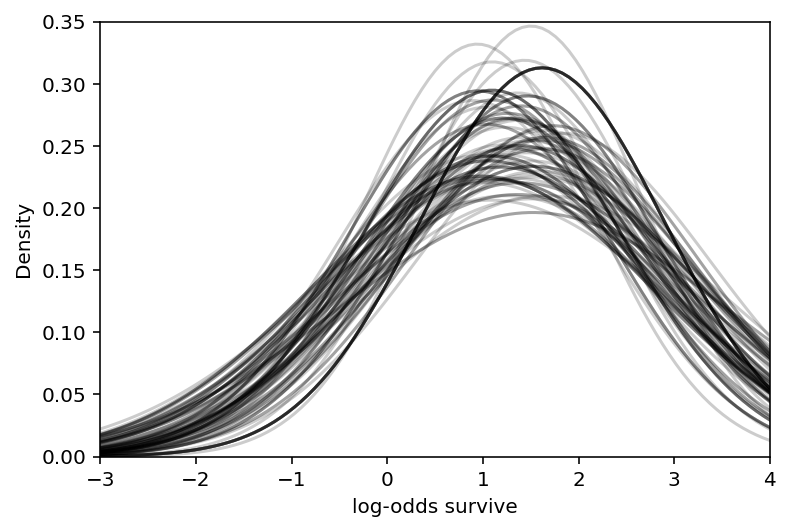

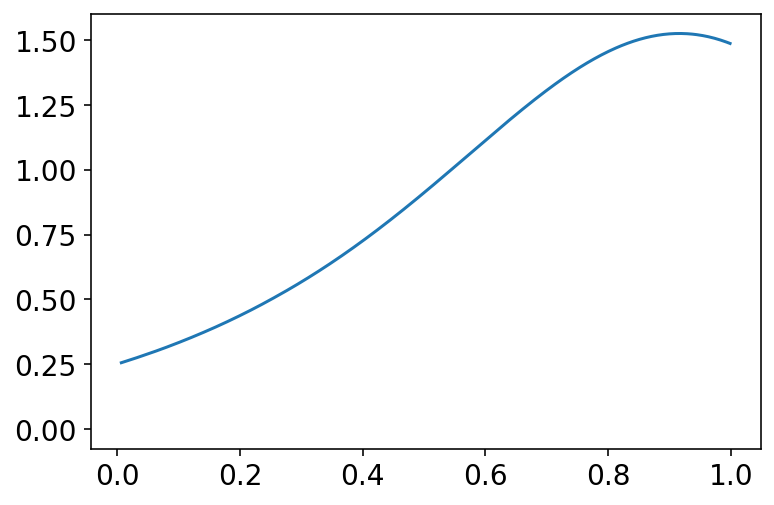

In [16]:
sample_sigma = trace_13_2.posterior["sigma"].values[0]

# show first 100 populations in the posterior
plt.subplot(xlim=(-3, 4), ylim=(0, 0.35),
            xlabel="log-odds survive", ylabel="Density")
for i in range(100):
    x = np.linspace(-3, 4, 101)
    plt.plot(x, tf.exp(tfd.Normal(sample_a_bar[i], sample_sigma[i])
                       .log_prob(x)), "k", alpha=0.2)
plt.show()

# sample 8000 imaginary tanks from the posterior distribution
idxs = np.random.randint(size=(8000,), low=0, high=499)

sim_tanks = tfd.Normal(sample_a_bar[idxs], sample_sigma[idxs]).sample()

# transform to probability and visualize
az.plot_kde(tf.sigmoid(sim_tanks).numpy(), bw=0.3);

## 13.2 Varying effects and the underlying/overfitting trade-off

### 13.2.1 The model

### 13.2.2 Assign values to the parameters

##### Code 13.7

In [17]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)

##### Code 13.8

In [18]:
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,))

##### Code 13.9

In [19]:
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))

dsim.describe()

,pond,Ni,true_a
count,60.000000,60.000000,60.000000
mean,30.500000,18.750000,1.440132
std,17.464249,12.024868,1.535202
min,1.000000,5.000000,-1.751318
25%,15.750000,8.750000,0.608319
50%,30.500000,17.500000,1.362845
75%,45.250000,27.500000,2.359282
max,60.000000,35.000000,5.666076


##### Code 13.10

In [20]:
print(type(range(3)))
print(type(np.arange(3)))

<class 'range'>
<class 'numpy.ndarray'>


### 13.2.3 Simulate survivors

##### Code 13.11

In [21]:
dsim["Si"] = tfd.Binomial(tf.cast(dsim.Ni.values, dtype=tf.float32), logits=dsim.true_a.values).sample()

### 13.2.4 Compute the no-pooling estimates

##### Code 13.12

In [22]:
dsim["p_nopool"] = dsim.Si / dsim.Ni

### 13.2.5 Compute partial pooling estimates

##### Code 13.13

In [23]:
alpha_sample_shape = dsim.pond.shape[0]

In [25]:
dsim["pond_adj"] = dsim.pond.values - 1

tdf = dataframe_to_tensors("SimulatedPonds", dsim, {
    "Si" : tf.float32,
    "true_a": tf.float32,
    "Ni": tf.float32,
    "pond_adj": tf.int32
})

In [26]:
def model_13_3(pid, N):
    def _generator():     
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma), sample_shape=alpha_sample_shape)
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, pid, axis=-1)))              
        
      Si = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_3 = model_13_3(tdf.pond_adj, tdf.Ni)

In [27]:
NUM_CHAINS_FOR_13_3 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_3]),
    tf.ones([NUM_CHAINS_FOR_13_3]),
    tf.zeros([NUM_CHAINS_FOR_13_3, alpha_sample_shape])
]

In [28]:
bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

In [29]:
posterior_13_3, trace_13_3 = sample_posterior(jdc_13_3,
                                   observed_data=(tdf.Si,),
                                   params=['a_bar', 'sigma', 'alpha'],
                                   num_chains=NUM_CHAINS_FOR_13_3, 
                                   init_state=init_state,
                                   bijectors=bijectors)

##### Code 13.14

In [30]:
az.summary(trace_13_3, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.25,0.19,0.98,1.57,0.01,0.01,168.10,188.89,1.01
sigma,1.36,0.18,1.06,1.62,0.02,0.02,59.95,173.71,1.03
alpha[0],1.24,0.92,-0.30,2.49,0.14,0.10,46.35,35.97,1.03
alpha[1],2.17,1.06,0.63,4.01,0.17,0.13,39.14,85.93,1.07
alpha[2],0.05,0.79,-0.98,1.42,0.09,0.07,65.27,105.18,1.06
...,...,...,...,...,...,...,...,...,...
alpha[55],1.57,0.42,0.93,2.22,0.03,0.02,244.73,186.15,1.01
alpha[56],2.19,0.55,1.35,3.02,0.05,0.04,161.51,126.28,1.01
alpha[57],0.98,0.36,0.46,1.56,0.02,0.01,338.22,333.12,1.01
alpha[58],-0.39,0.36,-1.03,0.10,0.02,0.01,392.99,231.32,1.00


##### Code 13.15

In [31]:
sample_alpha = trace_13_3.posterior["alpha"].values[0]
dsim["p_partpool"] = tf.reduce_mean(tf.sigmoid(sample_alpha)).numpy()

##### Code 13.16

In [32]:
dsim["p_true"] = tf.sigmoid(dsim.true_a.values).numpy()

##### Code 13.17

In [33]:
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()

##### Code 13.18

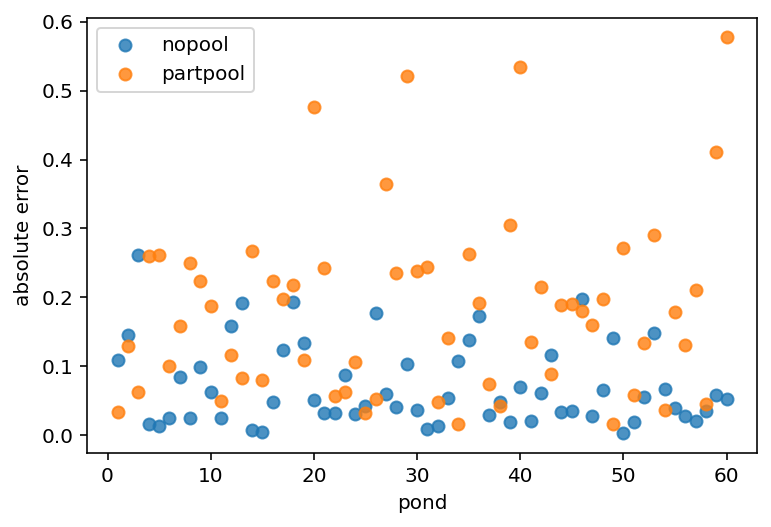

In [34]:
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

##### Code 13.19

In [35]:
dsim["nopool_error"] = nopool_error
dsim["partpool_error"] = partpool_error
nopool_avg = dsim.groupby("Ni")["nopool_error"].mean()
partpool_avg = dsim.groupby("Ni")["partpool_error"].mean()

### Overthiking: Repeating the pond simulation

##### Code 13.20

In [36]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,)).numpy()
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))
dsim["Si"] = tfd.Binomial(tf.cast(dsim.Ni.values, dtype=tf.float32), logits=dsim.true_a.values).sample()
dsim["p_nopool"] = dsim.Si / dsim.Ni

newdat = dict(Si=tf.cast(dsim.Si.values, dtype=tf.float32),
              Ni=tf.cast(dsim.Ni.values, dtype=tf.float32),
              pond=dsim.pond.values - 1
)

jdc_13_3new = model_13_3(newdat["pond"], newdat["Ni"])

In [37]:
posterior_13_3new, trace_13_3new = sample_posterior(jdc_13_3new,
                                       observed_data=(newdat["Si"],),
                                       params=['a_bar', 'sigma', 'alpha'],
                                       num_chains=NUM_CHAINS_FOR_13_3, 
                                       init_state=init_state,
                                       bijectors=bijectors)

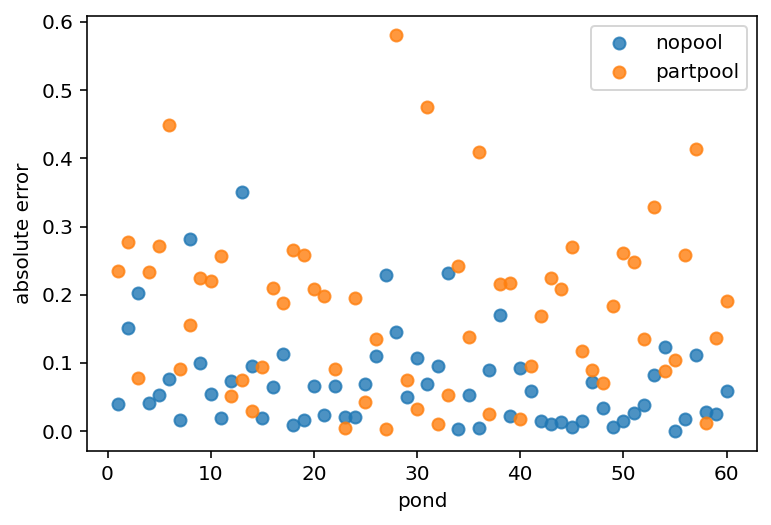

In [38]:
sample_alpha = trace_13_3new.posterior["alpha"].values[0]
dsim["p_partpool"] = tf.reduce_mean(tf.sigmoid(sample_alpha)).numpy()
dsim["p_true"] = tf.sigmoid(dsim.true_a.values).numpy()
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

## 13.3 More than one type of cluster

### 13.3.1 Multilevel chimpanzees

##### Code 13.21

In [40]:
d = RethinkingDataset.Chimpanzees.get_dataset()

d["treatment"] = 1 + d.prosoc_left + 2 * d.condition - 1
d["block_id"] = d.block.values - 1
d["actor_id"] = d.actor.values - 1

tdf = dataframe_to_tensors("Chimpanzee", d, {
    "treatment" : tf.int32,
    "block_id"  : tf.int32,
    "actor_id"  : tf.int32,
    "pulled_left" : tf.float32
})


def model_13_4(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      gamma = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_g), sample_shape=6)  
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(gamma, block_id, axis=-1))
      term3 = tf.squeeze(tf.gather(beta, treatment, axis=-1))
        
      p = tf.sigmoid(term1 + term2 + term3)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_4 = model_13_4(tdf.actor_id, tdf.block_id, tdf.treatment)

In [41]:
NUM_CHAINS_FOR_13_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

posterior_13_4, trace_13_4 = sample_posterior(jdc_13_4,
                               observed_data=(tdf.pulled_left,),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'alpha', 'gamma', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_4, 
                               init_state=init_state,
                               bijectors=bijectors)

##### Code 13.22

In [42]:
az.summary(trace_13_4, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.58,0.64,-0.24,1.62,0.09,0.06,52.63,76.75,1.03
sigma_a,1.85,0.64,0.83,2.69,0.12,0.08,29.05,17.62,1.07
sigma_g,0.25,0.15,0.05,0.46,0.02,0.02,34.47,17.62,1.03
alpha[0],-0.39,0.36,-0.91,0.21,0.05,0.03,64.42,69.04,1.03
alpha[1],4.47,1.23,2.62,6.34,0.38,0.28,12.40,21.59,1.17
alpha[2],-0.67,0.40,-1.29,-0.10,0.07,0.05,24.24,76.19,1.08
alpha[3],-0.68,0.37,-1.21,-0.08,0.05,0.04,52.11,64.51,1.04
alpha[4],-0.36,0.39,-0.93,0.25,0.06,0.04,31.58,62.65,1.06
alpha[5],0.58,0.35,-0.04,1.04,0.04,0.03,68.06,97.21,1.03
alpha[6],2.05,0.43,1.38,2.73,0.05,0.04,75.65,107.86,1.01


Note that there is variation across parameters when it comes to effective sample size (ess_mean). This is because some parameters spends a lot of time near a boundary. 

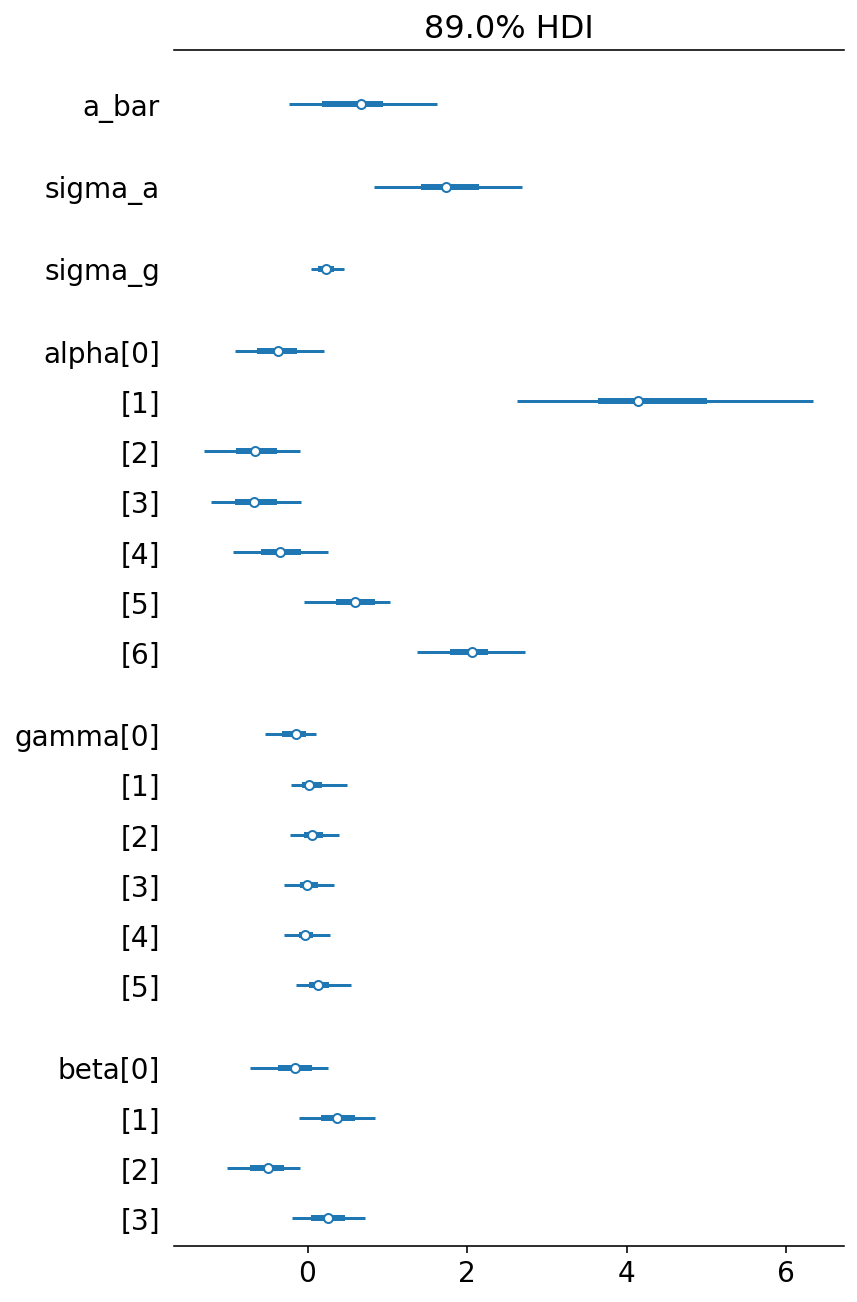

In [43]:
az.plot_forest(trace_13_4, combined=True, hdi_prob=0.89); 

##### Code 13.23

Build a model that ignores block so that we can then compare it with the above model

In [44]:
def model_13_5(actor, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # two terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_5 = model_13_5(tdf.actor_id, tdf.treatment)


NUM_CHAINS_FOR_13_5 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_5]),
    tf.ones([NUM_CHAINS_FOR_13_5]),    
    tf.zeros([NUM_CHAINS_FOR_13_5, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_5, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),        
    tfb.Identity(),
    tfb.Identity()
]

posterior_13_5, trace_13_5 = sample_posterior(jdc_13_5,
                               observed_data=(tdf.pulled_left,),
                               params=['a_bar', 'sigma_a', 'alpha', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_5, 
                               init_state=init_state,
                               bijectors=bijectors)

##### Code 13.24

In [45]:
def compute_and_store_log_likelihood_for_model_13_4():
    
    sample_a_bar    = posterior_13_4["a_bar"]
    sample_sigma_a  = posterior_13_4["sigma_a"]
    sample_sigma_g  = posterior_13_4["sigma_g"]
    
    sample_alpha = posterior_13_4["alpha"]
    sample_gamma = posterior_13_4["gamma"]
    sample_beta  = posterior_13_4["beta"]
    
    ds, _ = jdc_13_4.sample_distributions(value=[
        sample_a_bar,
        sample_sigma_a,
        sample_sigma_g,
        
        sample_alpha, 
        sample_gamma, 
        sample_beta, 
        None
    ])
    
    log_likelihood_13_4 = ds[-1].distribution.log_prob(tdf.pulled_left).numpy()

    # we need to insert this in the sampler_stats
    sample_stats_13_4 = trace_13_4.sample_stats

    coords = [sample_stats_13_4.coords['chain'], sample_stats_13_4.coords['draw'], np.arange(504)]

    sample_stats_13_4["log_likelihood"] = xr.DataArray(
        log_likelihood_13_4, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_4()

In [46]:
def compute_and_store_log_likelihood_for_model_13_5():
    
    sample_a_bar    = posterior_13_5["a_bar"]
    sample_sigma_a  = posterior_13_5["sigma_a"]
    
    sample_alpha = posterior_13_5["alpha"]
    sample_beta  = posterior_13_5["beta"]
    
    ds, _ = jdc_13_5.sample_distributions(value=[
        sample_a_bar, 
        sample_sigma_a,
                
        sample_alpha, 
        sample_beta, 
        None
    ])
    
    log_likelihood_13_5 = ds[-1].distribution.log_prob(tdf.pulled_left).numpy()

    # we need to insert this in the sampler_stats
    sample_stats_13_5 = trace_13_5.sample_stats

    coords = [sample_stats_13_5.coords['chain'], sample_stats_13_5.coords['draw'], np.arange(504)]

    sample_stats_13_5["log_likelihood"] = xr.DataArray(
        log_likelihood_13_5, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_5()

In [47]:
az.compare({"m13.4": trace_13_4, "m13.5": trace_13_5})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m13.5,0,-264.704218,8.072352,0.000000,1.0,9.793674,0.00000,False,log
m13.4,1,-266.452466,10.972167,1.748248,0.0,9.645800,1.07815,False,log


Above 2 models seem to imply nearly identical predictions. Should we select m13.4 as it is simpler among the two ?. Author here suggests that to select a model, we should rather want to test conditional independencies of different causal models.

### 13.3.2 Even more clusters

##### Code 13.25

m13.4 with partial pooling on the treatments

In [48]:
def model_13_6(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_b = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))  
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      gamma = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_g), sample_shape=6)  
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_b), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(gamma,block_id,axis=-1))
      term3 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2 + term3)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_6 = model_13_6(tdf.actor_id, tdf.block_id, tdf.treatment)

In [49]:
NUM_CHAINS_FOR_13_6 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

posterior_13_6, trace_13_6 = sample_posterior(jdc_13_6,
                               observed_data=(tdf.pulled_left,),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'sigma_b', 'alpha', 'gamma', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_6, 
                               init_state=init_state,
                               bijectors=bijectors)

In [50]:
{"m13.4": np.mean(trace_13_4.posterior["beta"].values[1], 0),
 "m13.6": np.mean(trace_13_6.posterior["beta"].values[1], 0)}

{'m13.4': array([-0.18678145,  0.39843377, -0.51063335,  0.27631298], dtype=float32),
 'm13.6': array([-0.00267644,  0.463095  , -0.3112636 ,  0.3730652 ], dtype=float32)}

## 13.4 Divergent transitions and non-centered priors

### 13.4.1 The Devil's Funnel

##### Code 13.26 (TODO - add notes on divergence)

In [51]:
def model_13_7():
    def _generator():  
      v = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=3.), sample_shape=1))
      x = yield tfd.Sample(tfd.Normal(loc=0., scale=tf.exp(v)), sample_shape=1)       
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_7 = model_13_7()

In [52]:
NUM_CHAINS_FOR_13_7 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_7]),
    tf.zeros([NUM_CHAINS_FOR_13_7])   
]

bijectors = [    
    tfb.Identity(),
    tfb.Identity()
]

posterior_13_7, trace_13_7 = sample_posterior(jdc_13_7,
                                   observed_data=(),
                                   params=['v', 'x'],
                                   num_chains=NUM_CHAINS_FOR_13_7, 
                                   init_state=init_state,
                                   bijectors=bijectors)

In [53]:
az.summary(trace_13_7, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,-1.644,1.109,-2.753,-0.525,0.778,0.657,3.0,2.0,2.29
x,0.503,0.650,-0.146,1.176,0.456,0.385,2.0,2.0,2.97


##### Code 13.27

In [54]:
def model_13_7nc():
    def _generator():  
      v = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=3.), sample_shape=1))
      z = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=1))
      x = z * tf.exp(v)
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_7nc = model_13_7nc()

NUM_CHAINS_FOR_13_7nc = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_7nc]),
    tf.zeros([NUM_CHAINS_FOR_13_7nc])   
]

bijectors = [    
    tfb.Identity(),
    tfb.Identity()
]

posterior_13_7nc, trace_13_7nc = sample_posterior(jdc_13_7nc,
                               observed_data=(),
                               params=['v', 'z'],
                               num_chains=NUM_CHAINS_FOR_13_7nc, 
                               init_state=init_state,
                               bijectors=bijectors)

az.summary(trace_13_7nc, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,-0.118,2.990,-4.698,4.559,0.081,0.096,1351.0,646.0,1.00
z,0.053,0.963,-1.451,1.534,0.065,0.046,222.0,270.0,1.01


### 13.4.2 Non-centered chimpanzees

##### Code 13.28 [TODO - parameterize the target accept prob]

##### Code 13.29

In [55]:
def model_13_4nc(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      z = yield tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=7)
      x = yield tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=6)  
      b = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(z, actor,     axis=-1))
      term2 = tf.squeeze(tf.gather(x, block_id,  axis=-1))
      term3 = tf.squeeze(tf.gather(b, treatment, axis=-1))        
        
      # reparamertization 
      r = a_bar[...,tf.newaxis] + sigma_a[...,tf.newaxis] * term1  \
                                + sigma_g[...,tf.newaxis] * term2  \
                                + term3
        
      p = tf.sigmoid(r)        
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_4nc = model_13_4nc(tdf.actor_id, tdf.block_id, tdf.treatment)

In [56]:
s = jdc_13_4nc.sample(2)

jdc_13_4nc.log_prob(s)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-275.64618, -278.36218],
       [-140.44714, -143.16315]], dtype=float32)>

In [57]:
NUM_CHAINS_FOR_13_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

posterior_13_4nc, trace_13_4nc = sample_posterior(jdc_13_4nc,
                               observed_data=(tdf.pulled_left,),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'z', 'x', 'b'],
                               num_chains=NUM_CHAINS_FOR_13_4, 
                               init_state=init_state,
                               bijectors=bijectors)

In [58]:
az.summary(trace_13_4nc, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.855,0.755,-0.231,2.146,0.222,0.161,13.0,35.0,1.15
sigma_a,1.738,0.454,1.067,2.391,0.095,0.068,21.0,82.0,1.09
sigma_g,0.185,0.194,0.003,0.367,0.040,0.029,17.0,66.0,1.09
z[0],-0.743,0.415,-1.353,-0.058,0.083,0.059,26.0,40.0,1.06
z[1],2.201,0.700,1.220,3.488,0.163,0.117,14.0,32.0,1.14
z[2],-0.946,0.461,-1.577,-0.215,0.094,0.067,24.0,41.0,1.08
z[3],-0.939,0.458,-1.569,-0.252,0.095,0.068,23.0,34.0,1.08
z[4],-0.749,0.419,-1.281,-0.035,0.087,0.062,23.0,42.0,1.07
z[5],-0.170,0.393,-0.725,0.490,0.081,0.058,24.0,56.0,1.09
z[6],0.756,0.440,-0.032,1.313,0.095,0.068,22.0,53.0,1.11


##### Code 13.30 [TODO - do not how to compute ess]

## 13.5 Multilevel posterior predictions

### 13.5.1 Posterior prediction for same clusters

##### Code 13.31

In [59]:
chimp = 2
d_pred = dict(actor=np.repeat(chimp, 4) - 1,
              treatment=np.arange(4),
              block_id=np.repeat(1, 4) - 1)

# we want to calculate the p using the posterior

sample_alpha = posterior_13_4["alpha"][0]
sample_gamma = posterior_13_4["gamma"][0]
sample_beta  = posterior_13_4["beta"][0]

term1 = tf.squeeze(tf.gather(sample_alpha, d_pred['actor'], axis=-1))
term2 = tf.squeeze(tf.gather(sample_gamma, d_pred['block_id'], axis=-1))
term3 = tf.squeeze(tf.gather(sample_beta, d_pred['treatment'], axis=-1))

p = tf.sigmoid(term1 + term2 + term3)

p_mu = tf.reduce_mean(p, 0)
p_ci = tfp.stats.percentile(p, q=(5.5, 94.5), axis=0)

p_mu, p_ci

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9774227 , 0.98642474, 0.9680966 , 0.9845367 ], dtype=float32)>,
 <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0.93534464, 0.9595532 , 0.8992131 , 0.9525901 ],
        [0.9992154 , 0.9996013 , 0.99911284, 0.9995743 ]], dtype=float32)>)

##### Code 13.32

In [60]:
{k: v.values[0].reshape(-1)[:5] for k, v in trace_13_4.posterior.items()}

{'a_bar': array([-1.6423249, -1.8482792, -1.8482792, -1.8482792, -1.7757103],
       dtype=float32),
 'sigma_a': array([2.0221171, 2.3936968, 2.3936968, 2.3936968, 2.1837535],
       dtype=float32),
 'sigma_g': array([0.46275258, 0.6446152 , 0.6446152 , 0.6446152 , 0.5893627 ],
       dtype=float32),
 'alpha': array([-1.0648303,  3.7633886, -1.3992662, -1.5625651, -0.779925 ],
       dtype=float32),
 'gamma': array([-0.31712443,  0.518165  ,  0.05902009,  0.5799209 ,  0.90846443],
       dtype=float32),
 'beta': array([-0.10415354,  0.7905861 , -0.49047446,  0.4811462 ,  0.02710183],
       dtype=float32)}

##### Code 13.33

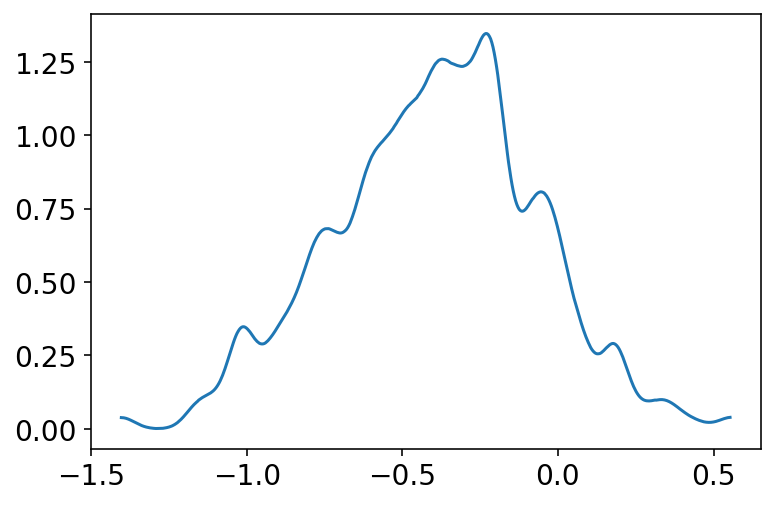

In [61]:
az.plot_kde(trace_13_4.posterior["alpha"].values[0][:, 4]);

##### Code 13.34

In [62]:
post = trace_13_4.posterior

In [63]:
def p_link(treatment, actor=0, block_id=0):    
    a, g, b = post["alpha"].values[0], post["gamma"].values[0], post["beta"].values[0]
    logodds = a[:, actor] + g[:, block_id] + b[:, treatment]
    return tf.sigmoid(logodds)

##### Code 13.35

In [64]:
p_raw = list(map(lambda i: p_link(i, actor=1, block_id=0), np.arange(4)))
p_mu = np.mean(p_raw, 0)
p_ci = np.percentile(p_raw, (5.5, 94.5), 0)

### 13.5.2 Posterior prediction for new clusters

##### Code 13.36

In [65]:
def p_link_abar(treatment):    
    logodds = post["a_bar"].values[0] + post["beta"].values[0][:, treatment]
    return tf.sigmoid(logodds)

##### Code 13.37

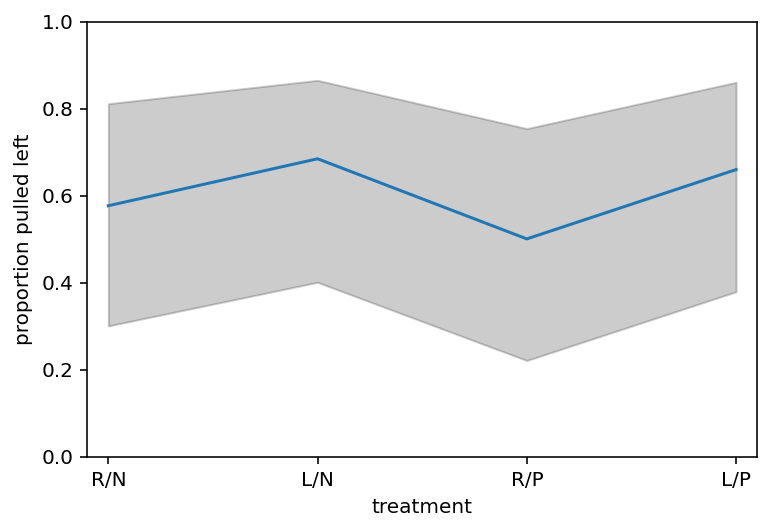

In [66]:
p_raw = list(map(p_link_abar, np.arange(4)))
p_mu = np.mean(p_raw, 1)
p_ci = np.percentile(p_raw, (5.5, 94.5), 1)

plt.subplot(xlabel="treatment", ylabel="proportion pulled left",
            ylim=(0, 1), xlim=(0.9, 4.1))
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
plt.plot(range(1, 5), p_mu)
plt.fill_between(range(1, 5), p_ci[0], p_ci[1], color="k", alpha=0.2);


##### Code 13.38

In [67]:
a_sim = tfd.Normal(loc=post["a_bar"].values[0], scale=post["sigma_a"].values[0]).sample()

def p_link_asim(treatment):
    logodds = a_sim + post["beta"].values[0][:, treatment]
    return tf.sigmoid(logodds)

p_raw_asim = np.array(list(map(p_link_asim, np.arange(4))))

##### Code 13.39

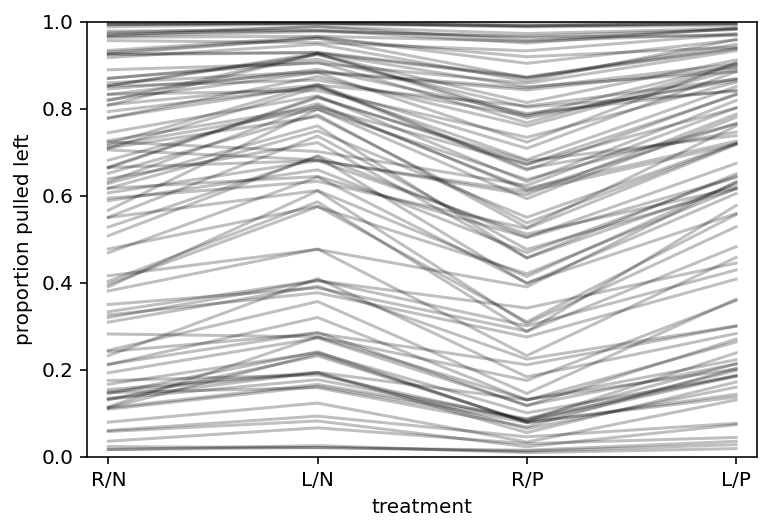

In [68]:
plt.subplot(xlabel="treatment", ylabel="proportion pulled left",
            ylim=(0, 1), xlim=(0.9, 4.1))
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
for i in range(100):
    plt.plot(range(1, 5), p_raw_asim[:, i], color="k", alpha=0.25)